In [1]:
import os
import gc
import cv2
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


# Configurations

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Mixed Precision and/or XLA

In [3]:
MIXED_PRECISION = False
XLA_ACCELERATE = False

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

# Read Dataset

In [4]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

def get_training_dataset(dataset, do_aug = True):
    if do_aug: 
        dataset = dataset.map(transform, num_parallel_calls = AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [5]:
disease_types=['COVID', 'non-COVID']
data_dir = '../input/sarscov2-ctscan-dataset/'
train_dir = os.path.join(data_dir)

In [6]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [7]:
IMAGE_SIZE = 64
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)


(2481, 64, 64, 3)
(2481,)


# KMeans Clustering for patients

The raw data does not contain patient ID for each image though there are multiple images come from the same pateints. Before split the train and validation sets, we need to make sure that images from the same patients do not appear in both sets to prevent data leakage. Here I use KMeans to cluster the images have close patterns for Covid and non-Covid separately. It is worth noting that we do not need to know the exact number of patients since we only need to roughly cluster those images that have close patterns. That is, one cluster can contain multiple patients.

In [8]:
from sklearn.cluster import KMeans

X0 = X[y == 0].reshape(len(X[y == 0]), -1)
X1 = X[y == 1].reshape(len(X[y == 1]), -1)

k = 50
kmeans = KMeans(k)
cluster0 = kmeans.fit_predict(X0)
cluster1 = kmeans.fit_predict(X1)
cluster1 += k
cluster = np.concatenate([cluster0, cluster1])

# Plot Images from The Same Cluster
It can be seen that the images from the same cluster are generally very similar to each other. They are more likely to be from the same patient. 

Some clusters contain multiple types of images. This means they contain images from multiple patients. Since we only want the images from the same patient to be in the same cluster, one cluster containing multiple patients does not matter.

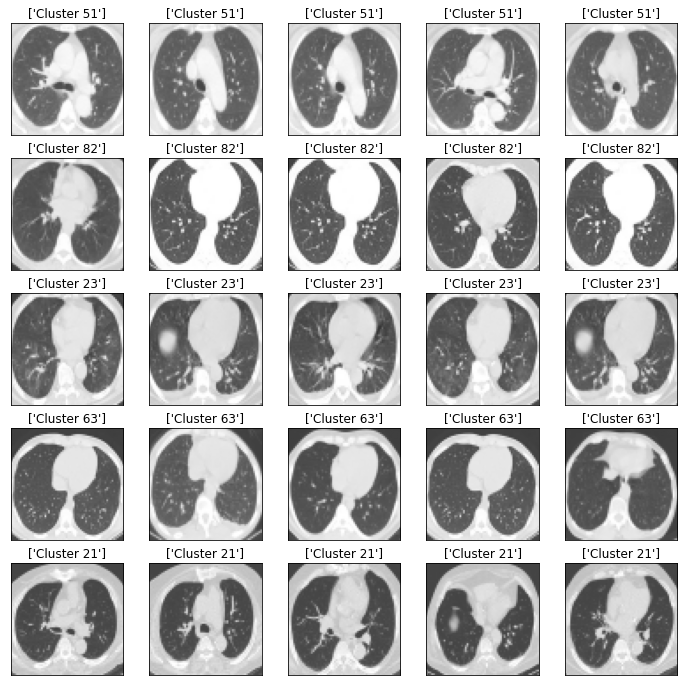

In [9]:
np.random.seed(42)

rows = 5 
cols = 5

fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows):
    clt = np.random.randint(0, 2 * k)
    clt_idx = np.random.choice(np.where(cluster == clt)[0], cols, replace = True)
    X_clt = X[clt_idx]
    for j in range(cols):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title([f'Cluster {clt}'])
        ax[i, j].imshow(X_clt[j])

# Create Training and Validation Sets

In [10]:
train_idx, val_idx = next(GroupShuffleSplit(test_size = 0.2, 
                                            n_splits = 2, 
                                            random_state = 42).split(X, groups = cluster))

X_train, X_val, Y_train, Y_val = X[train_idx], X[val_idx], y[train_idx], y[val_idx]

# Add Data Augmentation

In [11]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

train_dataset = get_training_dataset(tf.data.Dataset.from_tensor_slices((X_train, Y_train)))
val_dataset = get_validation_dataset(tf.data.Dataset.from_tensor_slices((X_val, Y_val)))

# Create Model

In [12]:
# EfficientNet models are not applicable on Tensorflow 2.2.0 for TPU
with strategy.scope():

    if not tpu:
        net = tf.keras.applications.EfficientNetB0(include_top = False,
                                                   weights = 'imagenet',
                                                   pooling = None)
    else:
        net = tf.keras.applications.DenseNet121(include_top = False,
                                                weights = 'imagenet',
                                                pooling = None)

    inp = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Conv2D(3, (3, 3), padding = 'same')(inp)
    x = net(x)
    x1 = GlobalAveragePooling2D()(x)
    x2 = GlobalMaxPooling2D()(x)
    x = Concatenate()([x1, x2])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation = 'sigmoid')(x)

    model = Model(inputs = inp, outputs = out)

    metric = tf.keras.metrics.AUC(name = 'auc')
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [metric])

model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 3)    84          input_2[0][0]                    
__________________________________________________________________________________________________
densenet121 (Model)             multiple             7037504     conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[1][0]                
_____________________________

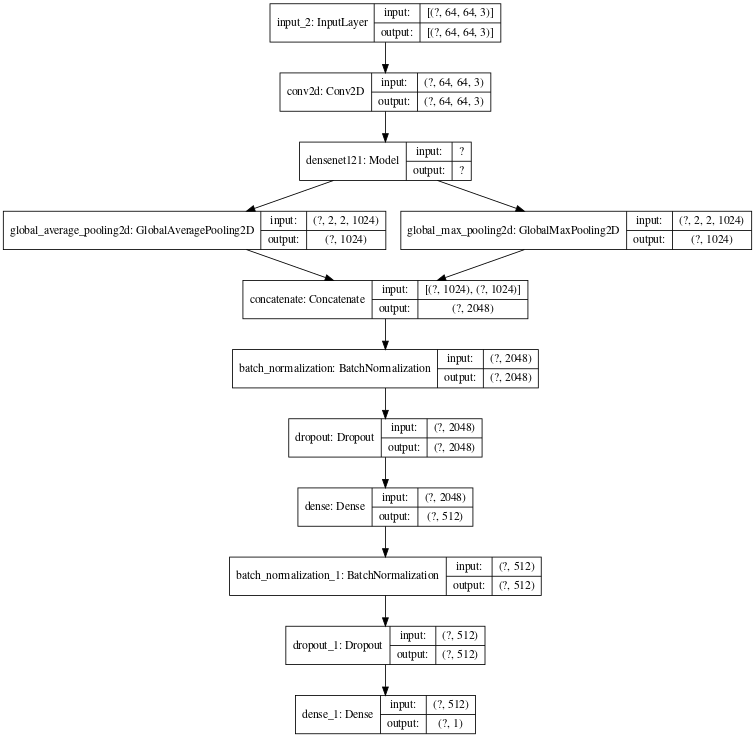

In [13]:
plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 60)

# Train Model

In [14]:
# Cosine Annealing Learning Rate from 'https://github.com/4uiiurz1/keras-cosine-annealing'
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [15]:
EPOCHS = 100

# earlystopping = EarlyStopping(monitor = 'val_auc', min_delta = 0.001, patience = 10, verbose = 1, mode = 'max', restore_best_weights = True)
# annealer = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.2, patience = 5, verbose = 1, min_lr = 1e-4, mode = 'max')
# checkpoint = ModelCheckpoint('model.h5', monitor = 'val_auc', verbose = 0, mode = 'max', save_best_only = True)
annealer = CosineAnnealingScheduler(EPOCHS, 1e-3, 1e-5)

hist = model.fit(train_dataset,
                 steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                 epochs = EPOCHS,
                 verbose = 1,
                 callbacks = [annealer],
                 validation_data = val_dataset)

Epoch 1/100
7/7 [==============================] - 21s 3s/step - auc: 0.6133 - loss: 0.9451 - val_auc: 0.5035 - val_loss: 6.4217 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 2s 280ms/step - auc: 0.7282 - loss: 0.8328 - val_auc: 0.5891 - val_loss: 3.5179 - lr: 9.9976e-04
Epoch 3/100
7/7 [==============================] - 2s 276ms/step - auc: 0.7974 - loss: 0.6897 - val_auc: 0.5279 - val_loss: 2.8200 - lr: 9.9902e-04
Epoch 4/100
7/7 [==============================] - 2s 256ms/step - auc: 0.8011 - loss: 0.6997 - val_auc: 0.5125 - val_loss: 2.3814 - lr: 9.9780e-04
Epoch 5/100
7/7 [==============================] - 2s 260ms/step - auc: 0.8028 - loss: 0.6451 - val_auc: 0.4821 - val_loss: 0.7630 - lr: 9.9610e-04
Epoch 6/100
7/7 [==============================] - 2s 259ms/step - auc: 0.8411 - loss: 0.5407 - val_auc: 0.4316 - val_loss: 2.4371 - lr: 9.9391e-04
Epoch 7/100
7/7 [==============================] - 2s 253ms/step - auc: 0.8662 - loss: 0.4976 - val_auc: 0.4209 - val_

# Plot AUC Score

Best Validation AUC:	 0.97


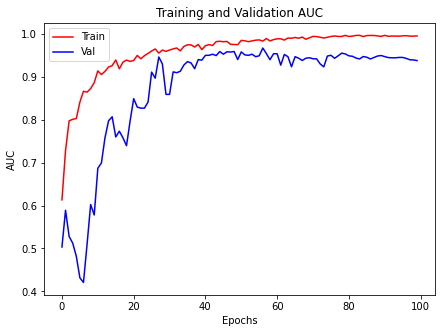

In [16]:
# AUC score is better than accuracy if the classes are imbalanced
print('Best Validation AUC:\t', round(max(hist.history['val_auc']), 2))

auc = hist.history['auc']
val_auc = hist.history['val_auc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(auc))

plt.figure(figsize = (7, 5))
plt.title('Training and Validation AUC')
plt.plot(epochs, auc, 'r', label = 'Train')
plt.plot(epochs, val_auc, 'b', label = 'Val')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc = 0)
plt.show()

In [17]:
pred_proba = model.predict(X_val)
auc_score = roc_auc_score(Y_val, pred_proba)
fpr, tpr, th = roc_curve(Y_val, pred_proba)
print('AUC Score:\t', round(auc_score, 2))

AUC Score:	 0.95


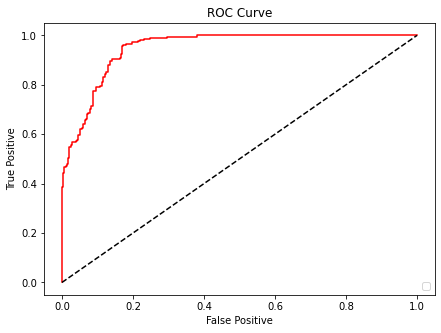

In [18]:
plt.figure(figsize = (7, 5))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'r')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend(loc = 4)
plt.show()

# Threshold Optimisation

In [19]:
def threshold_optimisation(y_true, y_pred, thresholds):
    best_th = thresholds[0]
    best_acc = accuracy_score(y_true, np.where(y_pred > thresholds[0], 1, 0))
    for th in thresholds[1:]:
        acc = accuracy_score(y_true, np.where(y_pred > th, 1, 0))
        if acc > best_acc:
            best_th = th
            best_acc = acc
    return best_acc, best_th

In [20]:
best_acc, best_th = threshold_optimisation(Y_val, pred_proba, th)
print('Best Accuracy:\t', round(best_acc, 2))
print('Best Threshold:\t', best_th)

Best Accuracy:	 0.88
Best Threshold:	 0.49549833
